<a href="https://colab.research.google.com/github/kevincallan/emotion_recognition/blob/main/KC_Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process Description 
The best performing contributors in the MediaEval competion used captions heavily when predicting the memorability score of a given video. Armed with this information this notebook will aim to use captions fundamentally along with the other pre computed features avaialble. However using encoded captions in the same model as the other pre-computed features leads to junk output as the features are of a entirely differnt scale. 


### This aprroach aims to do the following: 


1.   Extract Captions as features
2.   Use these encoded features in a simple neural net architecture to output a memorability score as a probability. 
3. Combine a model of caption and the other models of the other precomputed features with the aim of enhancing the prediction of memorability. 






# Ground Truth Data Set Exploration

Some exploration of the ground truth data set included analysis of the distribution of the memorability scores and the differences between long and short term memorability. 

First cells here cover the library dependencies 

In [ ]:
!pip install pyprind

In [ ]:
# data analysis packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# loading bar
# fix issue with tqdm and colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from pathlib import Path

     - 92kB 6.0MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-eobio3qe/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


Using TensorFlow backend.


In [ ]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA684_Assignment_Data/")
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
dev-set				     Memorability-Tutorial.ipynb
dev-set_aesthetic-features.zip	     Predictions_with_captions.ipynb
dev-set.zip			     sources.zip
load_features_barebones.ipynb	     test-set
MemorabilityDataset2018_license.txt


In [ ]:
!pwd

/content


In [ ]:
# ground_truth_file = 'dev-set/dev-set_ground-truth.csv'
# ground_truth = pd.read_csv(ground_truth_file)

ground_truth = pd.read_csv('dev-set/dev-set_ground-truth.csv', header = 0) 
ground_truth.head()

FileNotFoundError: ignored

### Plotting the histograms of both long and short term memorability. 


**Interestingly shorter term recall is skewed slightly more right than longer term, possibly 
indicating that it's hard to etch stuff into longer term memory.** 
The code to put this together is similar to the examples but is important to illastrate and explore the problem we're trying to solve.

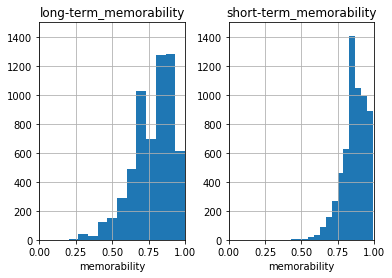

In [ ]:
bins = 15
figs = ground_truth[['short-term_memorability', 'long-term_memorability']].hist(bins=bins)

for fig in figs[0]:
  fig.set_xlabel('memorability')
  fig.set_ylim(0, 1500)
  fig.set_xlim(0, 1)
  fig.set_xlabel('memorability')
  fig.set_ylim(0, 1500)
  fig.set_xlim(0, 1)

# I put None at the end of any cell where the last statement is related to a plot
# Just removes some noise
# Remove the None to see what happens
None

### Density Distribution of Memorability Scores

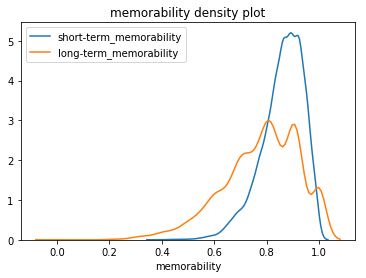

In [ ]:
for label in ['short-term_memorability', 'long-term_memorability']:
  sns.distplot(ground_truth[label], hist=False, label=label)
plt.xlabel('memorability')
plt.title('memorability density plot')

None

### Scatter plot showing an inconclusive relationship between a videos short and long term memorability. 

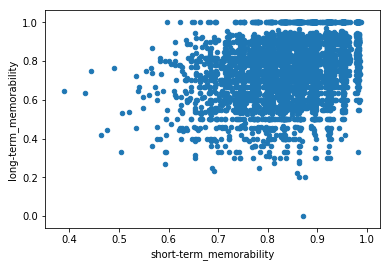

In [ ]:
(ground_truth[['short-term_memorability','long-term_memorability']]
  .plot(kind='scatter',
        x='short-term_memorability',
        y='long-term_memorability'))

# Precomputed Feature Processing & Captions From theMediaEval Dataset

Section Prepares the pre-computed features & Captions to prepare as inputs to various models

1.    Captions

5.   Fc7 layer from inception 





# Captions Processing 

Videos are manully captioned with a brief description of the content of the video 
e.g. "roulette table spinning with ball in closeup shot"

Use of captions by other participants in the MediaEval competition proved to be a very important feature in predicting memorability. 


In [ ]:
# load labels and captions from the dev set.
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

# load the captions
cap_path = 'dev-set/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = 'dev-set/'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

In [ ]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


In [ ]:
print(labels)

### Encoding of Each word. 

This encoding will act as preproscessing for the model. Without some form of encodeing or transformation from raw text the model input would not work. 

In [ ]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
print(len_token)

5191


In [ ]:
tokenizer.fit_on_texts(list(df_cap.caption.values)) 
#fit a list of captions to the tokenizer
#the tokenizer vectorizes a text corpus, by turning each text into either a sequence of integers 

In [ ]:
print(len(tokenizer.word_index))

5191


In [ ]:
# Prints a huge array with a row for each video and one hot for each word
one_hot_res = tokenizer.texts_to_matrix(list(df_cap.caption.values),mode='binary') 

sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))

In [ ]:
print(sequences)

[[724, 7, 35, 884, 384, 91], [2272, 85, 259, 6, 213, 1, 89, 27], [131, 312], [725, 993, 3098, 9, 165], [15, 118, 3, 515, 356, 27], [492, 31, 1478, 11, 146], [90, 726, 4, 62, 90, 65], [1796, 109, 29, 58, 385, 1797, 1, 1263], [3099, 2273, 313, 290], [18, 17, 994, 4, 118, 3, 2, 279], [995, 3, 2, 3100], [23, 21, 3, 3101, 8, 39, 469, 6, 1798, 386], [71, 53, 1799, 2274, 1479], [7, 2275, 3, 2, 59, 1, 2, 72, 115], [45, 5, 7, 1264, 35, 300, 3102, 1265, 14, 5, 493, 4, 660, 7, 2276, 21], [549, 3, 3103, 2277, 6, 3104, 1, 55], [30, 22, 82], [173, 8, 66, 147], [63, 3105, 885, 95, 8, 36], [1480, 550, 1800, 1801, 1481, 1, 1802, 3, 1266, 886], [15, 118, 1, 67, 81, 727], [18, 15, 118, 135, 2, 65, 996], [794, 229, 6, 25, 1125, 1, 5, 190, 3106, 1, 2, 1267, 24, 13, 470, 27], [73, 2278, 9, 2, 407], [38, 109, 68, 125, 4, 314, 3, 2, 148], [2279, 20, 661, 516], [165, 1268], [88, 8, 333, 42, 315, 1, 119], [53, 8, 191, 42, 3, 662], [887, 3107, 37, 66], [10, 11, 4, 7, 6, 5, 240, 8, 357, 48, 1, 2, 106, 60, 115], [

In [ ]:
#Visualise some stuff in sequences and counts
print(sequences[0]) # prints location of words from caption 0 'blonde woman is massaged tilt down'
print(counts['blonde']) # no. of occurences of 'blonde'
n=3
print('Least Common: ', counts.most_common()[:-n-1:-1])       # n least common elements
print('Most Common: ',counts.most_common(n))     

[724, 7, 35, 884, 384, 91]
10
Least Common:  [('unknown', 1), ('handheldshowing', 1), ('longof', 1)]
Most Common:  [('in', 2105), ('the', 1835), ('on', 1724)]


### x_seq computed here can now be used as a model input. 


In [ ]:
max_len = 50

X_seq = np.zeros((len(sequences),max_len))
for i in range(len(sequences)):
    n = len(sequences[i])
    if n==0:
        print(i)
    else:
        X_seq[i,-n:] = sequences[i]
X_seq.shape

(6000, 50)

In [ ]:
print(X_seq[0,:]) # length of 1st sequence after padding the caption with zeros.

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 724.   7.  35. 884. 384.  91.]


## Model Context
The model architecture in this notebook are all three layer neural nets. They take the features in question as the input layer and output a probability score from 0-1 as an output layer. This output layer is then compared with the ground truth memorability scores.  Spearman correlation coeeficent is then used as the primary evaluation metric as it is in both the example code and in the MediEval competition. 

Initially I had experimented with differnt layers and activation functions but noticed more value in experimenting with the feature processing and using one models output as another models input.  This notebook details some of these approaches with the first two models usuing individual features and then being combined in a new model with the aim of improving the prediction of memorability. 

#Captions Modelling 
### Inputting the caption into a model with the aim of using the output score as a scaled input into a subsequent model

In [ ]:
Y = labels[['short-term_memorability','long-term_memorability']].values # targetsc
X = X_seq # sequences

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

In [ ]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 50)
X_test (1200, 50)
Y_train (4800, 2)
Y_test (1200, 2)


In [ ]:
# add dropout - Helps prevent overfitting
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

model = Sequential() # The Sequential model is a linear stack of layers.

# You can simply add layers via the .add() method:
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(cap_max_len,))) # Just your regular densely-connected NN layer.
model.add(layers.Dropout(0.1)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='sigmoid'))

In [ ]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

In [ ]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 291us/step - loss: 0.3702 - acc: 0.6910 - val_loss: 0.2956 - val_acc: 0.7075
Epoch 2/20
4800/4800 [==============================] - 0s 44us/step - loss: 0.2265 - acc: 0.6942 - val_loss: 0.1617 - val_acc: 0.7067
Epoch 3/20
4800/4800 [==============================] - 0s 44us/step - loss: 0.1343 - acc: 0.6871 - val_loss: 0.0921 - val_acc: 0.6992
Epoch 4/20
4800/4800 [==============================] - 0s 43us/step - loss: 0.0835 - acc: 0.6865 - val_loss: 0.0646 - val_acc: 0.6925
Epoch 5/20
4800/4800 [==============================] - 0s 44us/step - loss: 0.0605 - acc: 0.6821 - val_loss: 0.0508 - val_acc: 0.6908
Epoch 6/20
4800/4800 [==============================] - 0s 45us/step - loss: 0.0484 - acc: 0.6679 - val_loss: 0.0415 - val_acc: 0.6800
Epoch 7/20
4800/4800 [==============================] - 0s 44us/step - loss: 0.0412 - acc: 0.6633 - val_loss: 0.0379 - val_acc: 0.6733
Epoch 

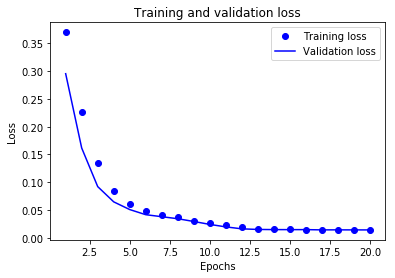

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

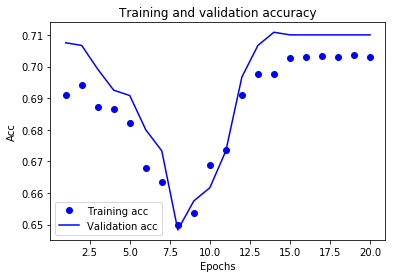

In [ ]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [ ]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

[[0.8615807  0.7783828 ]
 [0.8615807  0.7783828 ]
 [0.8668281  0.7841706 ]
 ...
 [0.8615807  0.7783828 ]
 [0.85407096 0.78053236]
 [0.8614943  0.777594  ]]
The Spearman's correlation coefficient is: 0.015
The Spearman's correlation coefficient is: -0.026


In [ ]:
model.save('/content/drive/My Drive/Memorability_assignment/captions_model.h5')

### Evaluating one hot encoding
One hot encoding is a cool way of evaluating the impact of specific words in isolation on the memorability score. 
In this instance when a particular word is present in a caption that words column will have a 1 if it is not present that word's column in the final array will have a 0

In [ ]:
one_hot_res.shape

(6000, 5191)

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 369us/step - loss: 0.0910 - acc: 0.4408 - val_loss: 0.0459 - val_acc: 0.2900
Epoch 2/20
4800/4800 [==============================] - 1s 119us/step - loss: 0.0449 - acc: 0.4894 - val_loss: 0.0204 - val_acc: 0.2933
Epoch 3/20
4800/4800 [==============================] - 1s 119us/step - loss: 0.0284 - acc: 0.5644 - val_loss: 0.0154 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 1s 124us/step - loss: 0.0214 - acc: 0.6498 - val_loss: 0.0146 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 1s 121us/step - loss: 0.0185 - acc: 0.6852 - val_loss: 0.0142 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 1s 118us/step - loss: 0.0171 - acc: 0.7040 - val_loss: 0.0141 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 1s 120us/step - loss: 0.0160 - acc: 0.7035 - val_loss: 0.0141 - val_acc: 0.7100


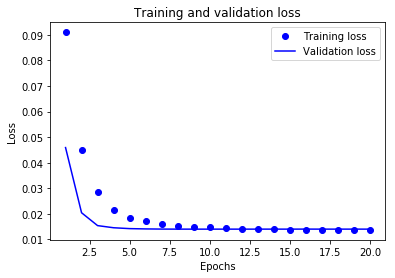

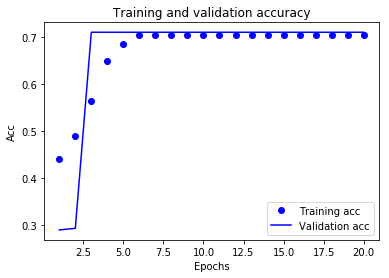

In [ ]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# add dropout
# add regularizers
model = Sequential()
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(len_token,)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Memorability_assignment/one_hot_model.h5')

In [ ]:
one_hot_caps_predictions = model.predict(X_test)
print(one_hot_caps_predictions.shape)
one_hot_model = model 


(1200, 2)


In [ ]:
print(one_hot_model)

Using one hot encoding from the provided examples we can compute a stronger memorability correlation to the ground truth memorability scrore. The value add of this project will be using this model output in combination with the Fc7 layer in an attempt to improve prediction here. 

In [ ]:
Get_score(one_hot_caps_predictions, Y_test)

The Spearman's correlation coefficient is: 0.273
The Spearman's correlation coefficient is: 0.151


In [ ]:
print (one_hot_caps_predictions)

[[0.8583356  0.7774879 ]
 [0.85744417 0.7766682 ]
 [0.8576328  0.776842  ]
 ...
 [0.85833055 0.7774834 ]
 [0.8580712  0.77724546]
 [0.85727787 0.7765161 ]]


# Inception Features Processing 
### Fc7 Layer

The cells below operate to take the precomputed features and prepare them to be inputting into the first layer of a neural network. 
It works by parsing the map which the provided file contains and storing in a python dictionary. 

This dictionary is then loaded into an array and passed through a model with the aim of computing a high correlation to the ground truth dataset. 

In [ ]:
inception_path = Path('InceptionV3')

!ls '{inception_path}' | head -10

video100-0.txt
video1001-0.txt
video1001-112.txt
video100-112.txt
video1001-56.txt
video1003-0.txt
video1003-112.txt
video1003-56.txt
video1004-0.txt
video1004-112.txt


In [ ]:
!ls '{inception_path}' | wc -l

18000


In [ ]:
example_inception_path = inception_path / 'video10-0.txt'
example_inception_path.open().read()

'8:2.811053e-38 12:4.527463e-34 58:7.063336e-34 107:4.006941e-31 110:9.993380e-01 112:4.186179e-35 123:1.304208e-37 294:7.722262e-37 295:2.903859e-32 323:6.014483e-33 392:5.602231e-38 396:4.263801e-33 524:1.684702e-38 543:1.156429e-24 546:3.005845e-19 611:4.177478e-38 618:3.339212e-32 693:2.644775e-29 714:6.619816e-04 725:3.289480e-21 765:2.632254e-36 773:5.967941e-14 811:2.472793e-36 850:5.449528e-35 852:1.594492e-28 857:4.170681e-37 864:3.997572e-36 883:1.215084e-17 899:2.787453e-31 951:1.757438e-27 961:9.840043e-27 984:7.116916e-26 \n'

In [ ]:
def parse_inception_feature(s):
    pairs = s.strip().split(' ')
    pairs = [i.split(':') for i in pairs]
    return {int(k): float(v) for k, v in pairs}

sample_inception_dictionary = parse_inception_feature(example_inception_path.open().read())


In [ ]:
def expand_inception_feature(d):
  feature = np.zeros(1000)
  for k, v in d.items():
    feature[k] = v
  return feature
  
# show first 20 values
expand_inception_feature(sample_inception_dictionary)[:20]

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       2.811053e-38, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       4.527463e-34, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00])

In [ ]:
sample_inception_dictionary

{8: 2.811053e-38,
 12: 4.527463e-34,
 58: 7.063336e-34,
 107: 4.006941e-31,
 110: 0.999338,
 112: 4.186179e-35,
 123: 1.304208e-37,
 294: 7.722262e-37,
 295: 2.903859e-32,
 323: 6.014483e-33,
 392: 5.602231e-38,
 396: 4.263801e-33,
 524: 1.684702e-38,
 543: 1.156429e-24,
 546: 3.005845e-19,
 611: 4.177478e-38,
 618: 3.339212e-32,
 693: 2.644775e-29,
 714: 0.0006619816,
 725: 3.28948e-21,
 765: 2.632254e-36,
 773: 5.967941e-14,
 811: 2.472793e-36,
 850: 5.449528e-35,
 852: 1.594492e-28,
 857: 4.170681e-37,
 864: 3.997572e-36,
 883: 1.215084e-17,
 899: 2.787453e-31,
 951: 1.757438e-27,
 961: 9.840043e-27,
 984: 7.116916e-26}

In [ ]:
# we will convert the keys using pathlib like this
example_inception_path.with_suffix('.webm').name.replace('-0', '')

'video10.webm'

In [ ]:
max_iterations = 6000 

In [ ]:
list(inception_path.glob('*-0.txt'))[:max_iterations]

In [ ]:
# this would take approximately 20 minutes to run if we were to do the whole thing in colab. 
# Better to cache results
max_iterations 

inception_features_dict = {}
for file in tqdm(list(inception_path.glob('*-0.txt'))[:max_iterations]):
  # only process first frame of each video
  key = file.with_suffix('.webm').name.replace('-0', '')
  inception_features_dict[key] = expand_inception_feature(
    parse_inception_feature(
      file.open().read()))

In [ ]:
# convert features to dataframe
inception_features = pd.DataFrame(inception_features_dict).T
inception_features.head(10)

In [ ]:
inception_features.loc['video1297.webm'].values[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
print(inception_features[2])

In [ ]:
inception_features.shape


(6000, 1000)

In [ ]:
max_len = 6000

In [ ]:
# Note: Only run this once

X_inception = np.zeros((len(inception_features),max_len))
for i in range(len(inception_features)):
    n = len(inception_features[i])
    if n==0:
        print(i)
    else:
        X_inception[i,-n:] = inception_features[i]
X_inception.shape


#Inception Layer Modelling
### Predicting Memorability with the Fc7 Layer from inception

In [ ]:
Y = labels[['short-term_memorability','long-term_memorability']].values # targets
X = X_inception

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

In [ ]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 6000)
X_test (1200, 6000)
Y_train (4800, 2)
Y_test (1200, 2)


In [ ]:
inception_features_np = inception_features.values

inception_features_np.shape

(6000, 1000)

In [ ]:
# calculating max length
max_len = 6000


## Using the Keras python package the below code builds and runs a three layer neural network and evalauates the Inception layer precomputed features
During experimentation I added and removed layers and altered the activation function. I didn't seem any meaningful Spearman correlation improvement from adding up tp seven layers so decided to stick to the default three for simplicity and try to improve the model performance by further experiments with features

In [ ]:
# add dropout - Helps prevent overfitting
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

model = Sequential() # The Sequential model is a linear stack of layers.

# You can simply add layers via the .add() method:
# You can simply add layers via the .add() method:
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,))) # Just your regular densely-connected NN layer.
model.add(layers.Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 10)                60010     
_________________________________________________________________
dropout_55 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_56 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 2)                 22        
Total params: 60,142
Trainable params: 60,142
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])
# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 408us/step - loss: 0.0813 - acc: 0.3708 - val_loss: 0.0401 - val_acc: 0.2900
Epoch 2/20
4800/4800 [==============================] - 1s 130us/step - loss: 0.0368 - acc: 0.4250 - val_loss: 0.0177 - val_acc: 0.7100
Epoch 3/20
4800/4800 [==============================] - 1s 130us/step - loss: 0.0263 - acc: 0.5915 - val_loss: 0.0153 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 1s 135us/step - loss: 0.0217 - acc: 0.6300 - val_loss: 0.0147 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 1s 131us/step - loss: 0.0191 - acc: 0.6692 - val_loss: 0.0144 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 1s 129us/step - loss: 0.0173 - acc: 0.6967 - val_loss: 0.0142 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 1s 131us/step - loss: 0.0165 - acc: 0.7035 - val_loss: 0.0141 - val_acc: 0.7100


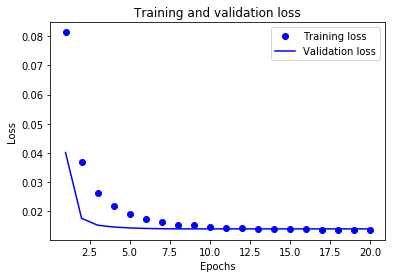

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

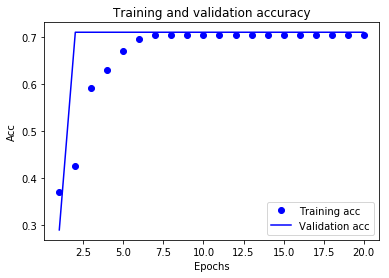

In [ ]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
fc7_predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

[[0.8615807  0.7783828 ]
 [0.8615807  0.7783828 ]
 [0.8668281  0.7841706 ]
 ...
 [0.8615807  0.7783828 ]
 [0.85407096 0.78053236]
 [0.8614943  0.777594  ]]
The Spearman's correlation coefficient is: 0.015
The Spearman's correlation coefficient is: -0.026


The two models are now stored in fc7_model and one_hotel_model

In [ ]:
fc7_model = model 

In [ ]:
print (fc7_model)
print (one_hot_model)

# Combination Modelling 
## Run the combinations of these two models through the a neural network to see if the correlation has been enhanced. (spoiler: it was not)

## Merge Models Output Features as an input into a Final Model

What I find really interesting about  using a multi model apprach concatenating the input layer with the output of the previous models could potentially improve predicability. This would work with models that use data of a different scale as the output layers in both models would be the  same. Unfortunatly, while this idea seemed novel to me did not yield enhance prediction of memorability

In [ ]:
#Keras functions taking the output of both model types and then performs some combination action. In this case Concatinating which in this case proved more effective that summing. 
from keras.layers import *

mergedOut = Concatenate()([one_hotel_model.output,fc7_model.output])
    #Concatenate adds the captions features to the input layer of the neural network  
    #Add() -> creates a merge layer that sums the inputs
    #The second parentheses "calls" the layer with the output tensors of the two models
    #it will demand that both model1 and model2 have the same output shape

In [ ]:
Y = labels[['short-term_memorability','long-term_memorability']].values # targets
X = mergedOut

In [ ]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 6000)
X_test (1200, 6000)
Y_train (4800, 2)
Y_test (1200, 2)


In [ ]:
max_len = 6000

Similar to the code of the previous model the it run the default 3 layer nn from the example. 

In [ ]:
# add dropout - Helps prevent overfitting
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

model = Sequential() # The Sequential model is a linear stack of layers.

# You can simply add layers via the .add() method:
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,))) # Just your regular densely-connected NN layer.
model.add(layers.Dropout(0.1)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='sigmoid'))

In [ ]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

In [ ]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 396us/step - loss: 0.0906 - acc: 0.7035 - val_loss: 0.0569 - val_acc: 0.7100
Epoch 2/20
4800/4800 [==============================] - 1s 128us/step - loss: 0.0343 - acc: 0.7033 - val_loss: 0.0171 - val_acc: 0.7100
Epoch 3/20
4800/4800 [==============================] - 1s 127us/step - loss: 0.0172 - acc: 0.6973 - val_loss: 0.0148 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 1s 130us/step - loss: 0.0157 - acc: 0.6967 - val_loss: 0.0146 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 1s 127us/step - loss: 0.0152 - acc: 0.6985 - val_loss: 0.0144 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 1s 127us/step - loss: 0.0149 - acc: 0.7023 - val_loss: 0.0142 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 1s 126us/step - loss: 0.0146 - acc: 0.7035 - val_loss: 0.0142 - val_acc: 0.7100


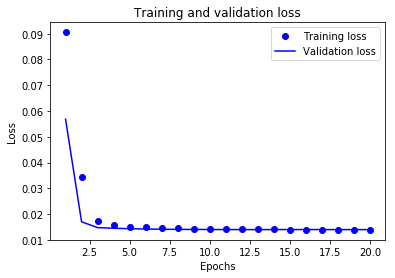

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The important takeaway from the graph below is the huge descropency between training an validation.  Indicating underfitting. 

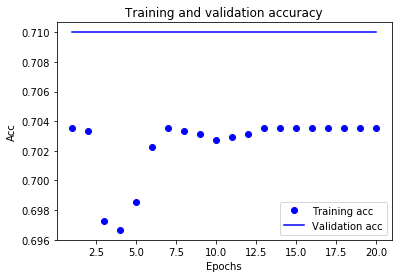

In [ ]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

[[0.85967875 0.77783966]
 [0.85967875 0.77783966]
 [0.85967875 0.77783966]
 ...
 [0.85967875 0.77783966]
 [0.85967875 0.77783966]
 [0.85967875 0.77783966]]
The Spearman's correlation coefficient is: 0.006
The Spearman's correlation coefficient is: 0.014


In [ ]:
model.save('/content/drive/My Drive/Memorability_assignment/mergered_model.h5')

## Since the best model perfomance was found using the one hot captions provided it makes sense to use this model on the test set.  Ahead of the other models or combinations of models

For the final submission it makes the most sense to sibmit the model with the highest performance despite trying some more novel but poorer performing approaches. 

Also worth noting that the functions to process the data have been altered to sccount for the fact that the test set has no ground truth. 

In [ ]:
# load labels and captions
def read_test_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
test_cap_path = 'Copy of test-set-1_video-captions.txt'
df_cap_test=read_caps(test_cap_path)



In [ ]:
!ls #Check file try to see to troubleshoot import

 captions_model.h5			  mergered_model.h5
'Colab Notebooks'			  Models
'Copy of ground_truth_template.csv'	  one_hot_model.h5
'Copy of test-set-1_video-captions.txt'  'test-set (1)'
 dev-set


In [ ]:
df_cap_test.head #Confirm test captions look reasonable and differnt to dev set

<bound method NDFrame.head of                 video                                            caption
0      video7494.webm     green jeep struggling to drive over huge rocks
1      video7495.webm  hiking woman tourist is walking forward in mou...
2      video7496.webm  close up of african american doctors hands usi...
3      video7497.webm  slow motion of a man using treadmill in the gy...
4      video7498.webm       slow motion of photographer in national park
5      video7499.webm  group of mixed race american patriotic peoples...
6      video7500.webm  business people train and draw diagrams on boa...
7      video7502.webm                       father and daughters smiling
8      video7503.webm  mechanic using a rotary polisher on a the pain...
9      video7504.webm  young couple having a conversation in hotel co...
10     video7505.webm                 jerusalem street market timelapse 
11     video7506.webm                     williamsburg capitol pan right
12     video7507.webm

In [ ]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap_test['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap_test['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap_test.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [ ]:
print(counts)
print(len(counts))

In [ ]:
# build the word index
len_token_test = len(counts)
tokenizer = Tokenizer(num_words=len_token_test)
print(len_token_test)

3197


In [ ]:
tokenizer .fit_on_texts(list(df_cap_test.caption.values)) #fit a list of captions to the tokenizer

In [ ]:
print(len(tokenizer_test.word_index))

3197


In [ ]:
print (tokenizer_test)

In [ ]:
#Note there is a different array shape here that will have to be altered to input into the first layer of previos models
one_hot_test.shape

(2000, 3197)

In [ ]:
#Code that encodes the captions in a binary fashion. 
one_hot_test = tokenizer.texts_to_matrix(list(df_cap_test.caption.values),mode='binary')

In [ ]:
X_new = one_hot_test

In [ ]:
#Creating an array with zeros to fit the input layer of the previous model 
pad = np.zeros((2000, 1994), dtype=X_new.dtype)

In [ ]:
#Combining the arrays to fit the input layer. Note that the extension of the array will contain all zeros so won't impact the model as the new elements contain no information. 
x_shaped = np.concatenate((X_new, pad),axis = 1)
x_shaped.shape

(2000, 5191)

In [ ]:
# Takes the new cleaned and processed features from the test set and used them in the previous highest performing model. 
y_new = one_hot_model.predict_proba(x_shaped)

In [ ]:
#Transforms the array into a data frame to output the results as a CSV to submit for the assignment. 
results_df = pd.DataFrame(data=y_new[1:,1:],    # values
             index=y_new[1:,0],    # 1st column as index
           columns=y_new[0,1:])  # 1st row as the column names
results_df.head()

,0.7760899662971497
0.858546,0.777682
0.857851,0.777042
0.858479,0.777620
0.857734,0.776935
0.858653,0.777781


In [ ]:
results_df.to_csv('results_v4.csv')